### Mount drive to datasets:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries and set `DATA_PATH`:

In [2]:
from pathlib import Path
import json
import glob
import numpy as np
import librosa
import os
from librosa import display
import matplotlib.pyplot as plt
import tensorflow as tf
from time import strftime
assert tf.__version__ >= "2.0"
# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE
DATA_PATH = '/content/drive/MyDrive'

### All paths to possible codecs:
All codec datasets are created for a binary problem. <br>
See configs in DLNet_config.json for details.

In [3]:
# Path to datasets:
# Full dataset (with all codecs)
path_medley_train = os.path.join(DATA_PATH, 'tf_dataset_MedleyDB_small', 'MedleyDB_train_set')
path_medley_test = os.path.join(DATA_PATH, 'tf_dataset_MedleyDB_small', 'MedleyDB_test_set')

### Read `config` and create `wrapper` object:
Each dataset has a config file included with the dataset configurations.<br>
Dataset configurations have to match to concatenate the datasets later.

In [4]:
 # Read configs from dataset:
json_file_codec =  os.path.join(os.path.split(path_medley_train)[0], 'DLNet_config.json')
with open(json_file_codec, "r") as read_file:
            config = json.load(read_file)
# Print Config:
print(json.dumps(config, sort_keys=False, indent=4))

{
    "audio_length": 1,
    "binary": false,
    "calculate_mel": false,
    "center": true,
    "classes": [
        "mp3_32k",
        "mp3_160k",
        "mp3_192k",
        "mp3_320k",
        "aac_128",
        "ogg_vbr",
        "uncompr_wav"
    ],
    "filter_signal": false,
    "hop_length": 256,
    "input_shape": [
        513,
        173,
        1
    ],
    "mono": true,
    "n_fft": 1024,
    "n_frames": 173,
    "n_mels": 64,
    "pad_mode": "reflect",
    "power": 2.0,
    "random_seed": 10,
    "sr": 44100,
    "time_stamp": "17_02_2021_22_17",
    "win_length": 512,
    "window": "hamm"
}


### Load chosen datasets and concatenate them:

In [5]:
# Load dataset:
# Codec1: (Compressed)
train_dataset = tf.data.experimental.load(path_medley_train,
                        (tf.TensorSpec(config['input_shape'],
                                       dtype=tf.float32, name=None),
                         tf.TensorSpec(len(config['classes']),
                                       dtype=tf.uint8, name=None)),
                        compression='GZIP')
test_dataset = tf.data.experimental.load(path_medley_test,
                        (tf.TensorSpec(config['input_shape'],
                                       dtype=tf.float32, name=None),
                         tf.TensorSpec(len(config['classes']),
                                       dtype=tf.uint8, name=None)),
                        compression='GZIP')


### Print dataset info:

In [6]:
print(train_dataset)
print(len(train_dataset))
print(test_dataset)
print(len(test_dataset))

<_LoadDataset shapes: ((513, 173, 1), (7,)), types: (tf.float32, tf.uint8)>
9800
<_LoadDataset shapes: ((513, 173, 1), (7,)), types: (tf.float32, tf.uint8)>
2450


### Prepare datasets:


*   Shuffle `train_dataset`
*   Take 10 % of `train_dataset` for evaluation: `eval_dataset`
*   Shuffle and batch rest of `train_dataset`
*   Batch `test_dataset`
*   Batch size: 64



In [7]:
train_size = len(train_dataset)
test_size = len(test_dataset)
eval_size = int(.1*train_size)
batch_size = 64

# Shuffel train data:
train_dataset = train_dataset.shuffle(buffer_size=int(train_size/3))

# Split train into train and eval set:
eval_dataset = train_dataset.take(eval_size)
eval_dataset = eval_dataset.batch(batch_size).prefetch(AUTOTUNE)

# Train dataset
train_dataset = train_dataset.skip(eval_size)
train_dataset = train_dataset.shuffle(train_size - eval_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(AUTOTUNE)

# Prepare test dataset
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)


### Create and compile CNN Model:

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=config['input_shape']))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.GlobalMaxPool2D())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Dense(len(config['classes']), activation="softmax"))

# Define metrics
metrics = [tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.FalseNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
           ]

# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

### Train and evaluate model:

In [9]:
# fit model
n_epochs = 17
history = model.fit(train_dataset, epochs=n_epochs,
                    validation_data=eval_dataset, verbose=1)

model.evaluate(test_dataset, batch_size=64)

Epoch 1/17
138/138 [==============================] - 99s 239ms/step - loss: 1.7750 - true_negatives: 26843.5683 - true_positives: 365.8345 - false_negatives: 4113.5324 - false_positives: 32.6331 - precision: 0.7505 - recall: 0.0576 - categorical_accuracy: 0.2678 - val_loss: 1.8612 - val_true_negatives: 5860.0000 - val_true_positives: 0.0000e+00 - val_false_negatives: 980.0000 - val_false_positives: 20.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_categorical_accuracy: 0.0214
Epoch 2/17
138/138 [==============================] - 49s 164ms/step - loss: 1.3170 - true_negatives: 26730.3741 - true_positives: 1192.9424 - false_negatives: 3286.4245 - false_positives: 145.8273 - precision: 0.8943 - recall: 0.2479 - categorical_accuracy: 0.4520 - val_loss: 1.6047 - val_true_negatives: 5841.0000 - val_true_positives: 0.0000e+00 - val_false_negatives: 980.0000 - val_false_positives: 39.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_categorical_accuracy: 0.3153


[0.6399754881858826,
 14324.0,
 1698.0,
 752.0,
 376.0,
 0.8187078237533569,
 0.6930612325668335,
 0.745306134223938]

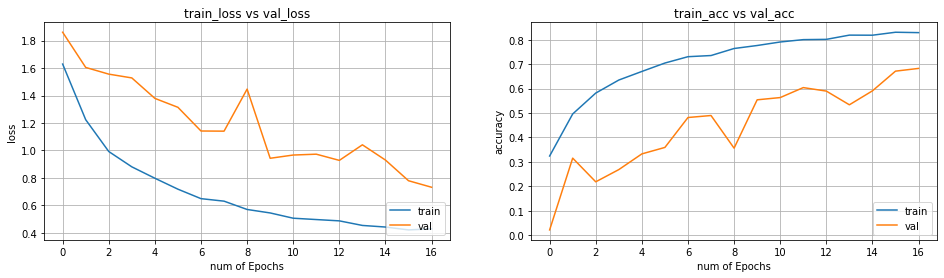

In [11]:
# setup plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,4))

# plot loss
ax[0].plot(range(n_epochs), history.history['loss'])
ax[0].plot(range(n_epochs), history.history['val_loss'])
ax[0].set_ylabel('loss'), ax[0].set_title('train_loss vs val_loss')

# plot accuracy
ax[1].plot(range(n_epochs), history.history['categorical_accuracy'])
ax[1].plot(range(n_epochs), history.history['val_categorical_accuracy'])
ax[1].set_ylabel('accuracy'), ax[1].set_title('train_acc vs val_acc')

# plot adjustement
for a in ax:
    a.grid(True)
    a.legend(['train','val'], loc=4)
    a.set_xlabel('num of Epochs')
plt.show()


### Model prediction as numpy arrays:

In [12]:
y_test_prob = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_prob, axis=1)
y_test_true = np.argmax(np.array([y for x, y in test_dataset.unbatch().as_numpy_iterator()]), axis=1)

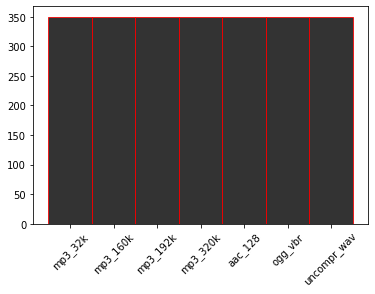

In [27]:
# Check label distribution in test set:
plt.hist(y_test_true, align='mid', bins=range(len(config['classes'])+1), linewidth=1, color='black', edgecolor='red', rwidth=1, alpha=.8)
plt.xticks([.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], config['classes'], rotation=45)
plt.show()

### Print metrics with sklearn:

In [28]:
from sklearn.metrics import classification_report

print('Classification report:')
print(classification_report(y_true=y_test_true, y_pred=y_test_pred,
                            target_names=config['classes']))

print('------------------------------------------------:')
print('Evaluate model on test dataset:')
hist_eval = model.evaluate(test_dataset)

print('------------------------------------------------:')
print('Evaluate model on eval dataset:')
hist_eval = model.evaluate(eval_dataset)

Classification report:
              precision    recall  f1-score   support

     mp3_32k       1.00      1.00      1.00       350
    mp3_160k       0.50      0.67      0.57       350
    mp3_192k       0.55      0.34      0.42       350
    mp3_320k       0.88      0.67      0.76       350
     aac_128       0.96      0.96      0.96       350
     ogg_vbr       0.51      0.67      0.58       350
 uncompr_wav       0.93      0.92      0.93       350

    accuracy                           0.75      2450
   macro avg       0.76      0.75      0.74      2450
weighted avg       0.76      0.75      0.74      2450

------------------------------------------------:
Evaluate model on test dataset:
39/39 [==============================] - 7s 185ms/step - loss: 0.6400 - true_negatives: 14324.0000 - true_positives: 1698.0000 - false_negatives: 752.0000 - false_positives: 376.0000 - precision: 0.8187 - recall: 0.6931 - categorical_accuracy: 0.7453
-----------------------------------------------

### Confusion Matrix:

Confusion matrix, without normalization


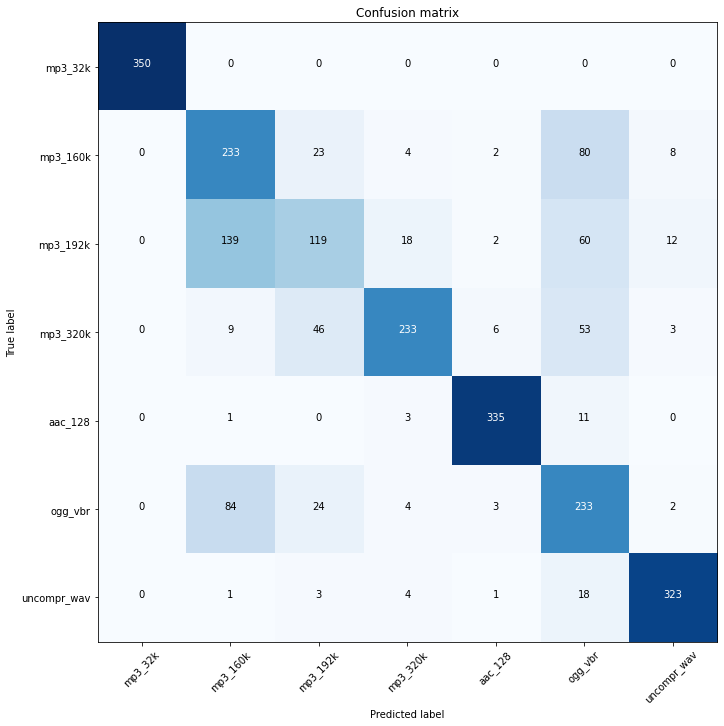

In [29]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label'), plt.xlabel('Predicted label')

# call confusion matrix
cm = tf.math.confusion_matrix(labels=y_test_true, predictions=y_test_pred)
cm = cm.numpy()
plot_confusion_matrix(cm, classes=config['classes'], normalize=False,
                      title='Confusion matrix', cmap=plt.cm.Blues)